In [18]:
import numpy as np

In [19]:
from lightexperiments.light import Light
import tabulate
from pyearth import Earth
from sklearn.cross_validation import cross_val_score, KFold, ShuffleSplit, Bootstrap
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor
from itertools import product
import pandas as pd
from sklearn.utils import shuffle
import pydot
from IPython.display import SVG

In [20]:
light = Light()

In [21]:
light.launch()

In [22]:
exp = []
for e  in light.db.find({"tags": ["model_hyperparameters"]}):
    exp.append(e)
light.close()

In [26]:
df = pd.DataFrame(exp)
df = df[df["name"]=="NADE"]
df = df[df["dataset"]=="digits"]

In [40]:
labels = ["batch_size", 
          #"latent_dim",
          "learning_rate", 
          "momentum", 
          "nb_units",#nade
          "nb_layers",#nade
        #  "nb_layers_decoder", # va
        #  "nb_layers_encoder", # va
        #  "nb_units_encoder",  # va
        #  "nb_units_decoder"   # va
]
X = df[labels].values
y = df[["score"]].values
y = y[:, 0]
print(X.shape, y.shape)
print(y)

((100, 5), (100,))
[ 27.20050235  27.1832049   27.20474816  27.18412146  27.24703035
  27.21033584  27.25548462  27.18803611  27.19624361  27.20801612
  27.20500067  27.21120209  27.19808087  27.19607306  27.20859658
  27.18166228  27.18376715  27.20991401  27.19834385  27.21789802
  27.19631802  27.18785283  27.22870627  27.20002114  27.19052643
  27.20409073  27.2194152   27.19546126  27.18705766  27.18106971
  27.20246508  27.16103614  27.17882936  27.20015001  27.223667
  27.19526501  27.20814254  27.18729217  27.22395826  27.19443601
  27.21004807  27.19055718  27.19820918  27.19264673  27.1901641
  27.18347562  27.20030501  27.21919784  27.20091292  27.20918373
  27.19188279  27.24646021  27.22615788  27.20514308  27.21277807
  27.22100027  27.18499146  27.19341929  27.208734    27.18618658
  27.20638991  27.18267969  27.19532021  27.22003258  27.16356973
  27.20900813  27.22400984  27.20630376  27.18988198  27.20957874
  27.18643273  27.19076501  27.20930367  27.18200881  27.173

In [41]:
#model = LinearRegression()
model = Earth(max_terms=40,
              thresh=0,
              max_degree=20)
#model = RandomForestRegressor(n_estimators=300, max_depth=1)
from sklearn.gaussian_process import GaussianProcess
scores = cross_val_score(model, 
                         X, 
                         y, 
                        # fit_params=dict(linvars=labels, xlabels=labels),
                         cv=5, 
                         scoring=lambda est, X, y:((est.predict(X)-y)**2).mean())
print(scores)
print(scores.mean(), scores.std())

[ 0.00039794  0.00026805  0.00027688  0.00027342  0.00033143]
(0.00030954481160380026, 4.9769781039680689e-05)


In [43]:
%%time
models = []
mse=[]
for train, test in KFold(X.shape[0], n_folds=5):
    model = Earth(max_terms=10, 
                  thresh=0.001, 
                  check_every=1,
                  penalty=10,
                  enable_pruning=True,
                  #smooth=True,
                  max_degree=5)
    #model = RandomForestRegressor(n_estimators=300, max_depth=10)
    #model.fit(X[train], y[train])
    model.fit(X[train], y[train],
              #linvars=labels,
    #          xlabels=labels
    )
    #pqrint(model.summary())
    m_train=((np.abs(model.predict(X[train]) - y[train])).mean())
    m_test=((np.abs(model.predict(X[test]) - y[test])).mean())
    print("train : {0}, test : {1}".format(m_train, m_test))
    mse.append(m_test)
    models.append(model)
mse = np.array(mse)
print(mse)
print(mse.mean(), mse.std())

train : 0.0131413422345, test : 0.0137995227747
train : 0.0135243177569, test : 0.0126942839852
train : 0.0134254343044, test : 0.0126631544949
train : 0.0130852138594, test : 0.0146047558575
train : 0.0133756468833, test : 0.0141125743789
[ 0.01379952  0.01269428  0.01266315  0.01460476  0.01411257]
(0.01357485829824423, 0.00077548908940683467)
CPU times: user 252 ms, sys: 9 ms, total: 261 ms
Wall time: 259 ms


In [44]:
def draw(models, thresh=0.8):
    graph = pydot.Dot(graph_type='graph')

    nodes = dict()
    for label in labels:
        nodes[label] = pydot.Node(label)
    nodes_used = set()
    
    for model in models:
        for bf in model.basis_:
            nodes_used |= set([labels[v] for v in bf.variables()])
    for node in nodes_used:
        graph.add_node(nodes[node])

    all_edges = dict()
    for model in models:
        edges = dict()

        for bf in model.basis_:
            names = [labels[v] for v in bf.variables()]
            for n1, n2 in product(names, repeat=2):
                if n1 == n2:
                    continue
                if n1 < n2:
                    n1, n2 = n2, n1
                if (n1, n2) not in edges:
                    edges[(n1, n2)] = 1                    
                else:
                    edges[(n1, n2)] += 1
        for n1, n2 in edges.keys():
            if (n1, n2) in all_edges:
                all_edges[(n1,  n2)] += 1
            else:
                all_edges[(n1, n2)] = 1
    
    for (n1, n2), nb in all_edges.items():
        ratio =  float(nb) / len(models)
        if ratio >= thresh:
            edge = pydot.Edge(nodes[n1], nodes[n2])
            graph.add_edge(edge)
    graph.write_svg('a.svg')
    return SVG("a.svg") 

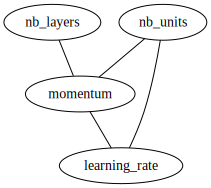

In [48]:
draw(models, thresh=0.6)